# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# H1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_h1_feature = pd.read_csv('../data/df_h1_feature.csv', index_col=0)
df_h1_feature.index = pd.to_datetime(df_h1_feature.index)
df_h1_feature = df_h1_feature.dropna()
df_h1_feature.head()

,open,high,low,close,results,hr_of_day,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,1.0424,1.0428,1.0408,1.0410,2,12,1,1.0423,-1.3,1.0436,-2.6,1.0435,-2.5,1.0429,-1.9,1.0410,0.0,1.0440,-3.0,1.0472,-6.2,1.0434,-2.4,1.0393,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,1.042300,-1.300000,1.04240,-1.40,1.042125,-1.1250,1.042446,-1.446154,1.043314,-2.314286,1.044912,-3.911765,1.043765,-2.765455,1.042664,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,-0.0013,0.0000,0.0013,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-0.659512,8.784831,-5.689276,-6.348788,3.095555,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,1.0409,1.0425,1.0408,1.0413,2,13,1,1.0410,0.3,1.0423,-1

In [3]:
df_h1_feature.shape

(105518, 186)

In [4]:
df_h1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105518 entries, 2003-01-07 12:00:00 to 2019-12-30 16:00:00
Columns: 186 entries, open to rsi_14_sma_21m02
dtypes: float64(183), int64(3)
memory usage: 150.5 MB


In [5]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_h1_feature.columns if col not in non_feature]

X = df_h1_feature[features]
y = df_h1_feature['results']

## Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,hr_of_day,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,12,1,-1.3,-2.6,-2.5,-1.9,0.0,-3.0,-6.2,-2.4,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,-1.300000,-1.40,-1.1250,-1.446154,-2.314286,-3.911765,-2.765455,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-0.659512,8.784831,-5.689276,-6.348788,3.095555,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,13,1,0.3,-1.0,-2.3,-0.3,0.1,-2.6,-5.2,-4.6,3.7,1.0487,-7.4,1.3,1.3,2.6,-2.0,-0.7,0.6,-0.4,-2.4,-1.1,0.2,2.7,2.3,0.3,1.6,2.9,2.6,5.3,4.9,2.9,4.2,5.5,-0.6,2.0,4.7,4.3,2.3,3.6,4.9,-8.3,-8.9,-6.3,-3.6,-4.0,-6.0,-4.7,-3.4,11.1,2.8,2.2,4.8,7.5,7.1,5.1,6.4,7.7,1.04115,0.15,-0.233333,-1.04,-0.8375,-0.946154,-1.766667,-3.476471,-2.532727,-1.280899,0.383333,0.806667,1.19,-0.2025,0.604167,0.9875,0.108654,-0.093846,0.712821,1.096

In [8]:
print(X_train.shape)
print(X_test.shape)

(79138, 161)
(26380, 161)


In [9]:
y_train.value_counts(normalize=True)

1    0.449102
2    0.434077
0    0.116821
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.343101
2    0.330781
0    0.326118
Name: results, dtype: float64

## Standard Scaler

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## RNN

### un-randomized train set

In [12]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 1

In [13]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [15]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
310/310 [==============================] - 5s 17ms/step - loss: 1.4784 - categorical_accuracy: 0.4431 - val_loss: 1.2872 - val_categorical_accuracy: 0.3427
Epoch 2/50
310/310 [==============================] - 5s 16ms/step - loss: 0.9881 - categorical_accuracy: 0.4510 - val_loss: 1.2002 - val_categorical_accuracy: 0.3433
Epoch 3/50
310/310 [==============================] - 5s 17ms/step - loss: 0.9550 - categorical_accuracy: 0.4590 - val_loss: 1.1782 - val_categorical_accuracy: 0.3424
Epoch 4/50
310/310 [==============================] - 5s 17ms/step - loss: 0.9466 - categorical_accuracy: 0.4556 - val_loss: 1.1532 - val_categorical_accuracy: 0.3436
Epoch 5/50
310/310 [==============================] - 5s 18ms/step - loss: 0.9442 - categorical_accuracy: 0.4551 - val_loss: 1.1518 - val_categorical_accuracy: 0.3478
Epoch 6/50
310/310 [==============================] - 6s 19ms/step - loss: 0.9387 - categ

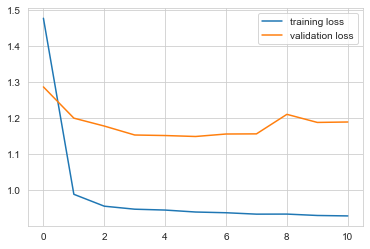

In [18]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

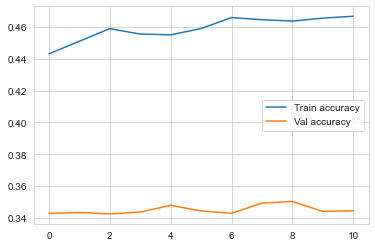

In [19]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [20]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,7841,762
actual 1,0,8125,926
actual 2,0,7764,961


In [21]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.342393594605984

In [22]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3627784069460174

In [23]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3444406535501725

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.169264,0.433517,0.397219
1,0.157141,0.441504,0.401354
2,0.198869,0.410014,0.391117
3,0.147979,0.439078,0.412943
4,0.146418,0.442189,0.411393


In [26]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,1,1,0.169264,0.433517,0.397219
2015-10-01 18:00:00,18,1,1,1,0.157141,0.441504,0.401354
2015-10-01 19:00:00,19,1,1,1,0.198869,0.410014,0.391117
2015-10-01 20:00:00,20,1,1,1,0.147979,0.439078,0.412943
2015-10-01 21:00:00,21,2,1,0,0.146418,0.442189,0.411393


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,1,1,0.169264,0.433517,0.397219
2015-10-01 18:00:00,18,1,1,1,0.157141,0.441504,0.401354
2015-10-01 19:00:00,19,1,1,1,0.198869,0.410014,0.391117
2015-10-01 20:00:00,20,1,1,1,0.147979,0.439078,0.412943
2015-10-01 21:00:00,21,2,1,0,0.146418,0.442189,0.411393


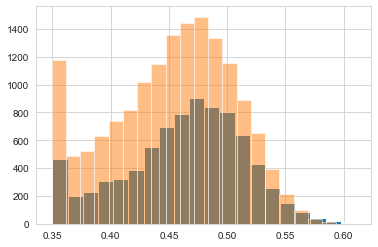

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 04:00:00,4,1,2,0,0.082355,0.454412,0.463233
2015-10-02 05:00:00,5,1,2,0,0.091141,0.440814,0.468045
2015-10-02 06:00:00,6,1,2,0,0.110799,0.419732,0.469469
2015-10-02 07:00:00,7,1,2,0,0.156586,0.406525,0.436889
2015-10-02 08:00:00,8,2,2,1,0.155698,0.407589,0.436713


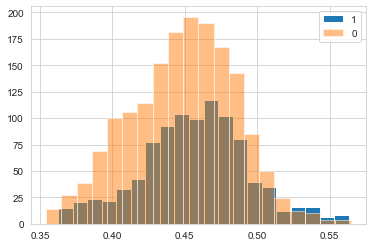

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [32]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 3

In [33]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [34]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [35]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [36]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [37]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 14s 46ms/step - loss: 1.5725 - categorical_accuracy: 0.4494 - val_loss: 1.3327 - val_categorical_accuracy: 0.3429
Epoch 2/50
310/310 [==============================] - 14s 45ms/step - loss: 1.0118 - categorical_accuracy: 0.4572 - val_loss: 1.2266 - val_categorical_accuracy: 0.3429
Epoch 3/50
310/310 [==============================] - 14s 46ms/step - loss: 0.9608 - categorical_accuracy: 0.4591 - val_loss: 1.2121 - val_categorical_accuracy: 0.3484
Epoch 4/50
310/310 [==============================] - 14s 46ms/step - loss: 0.9496 - categorical_accuracy: 0.4566 - val_loss: 1.1652 - val_categorical_accuracy: 0.3474
Epoch 5/50
310/310 [==============================] - 14s 45ms/step - loss: 0.9457 - categorical_accuracy: 0.4528 - val_loss: 1.2834 - val_categorical_accuracy: 0.3462
Epoch 6/50
310/310 [==============================] - 14s 45ms/step - loss: 0.9383 - categorical_accuracy: 0.4583 - val_loss: 1.3917 - val_categorical_accuracy:

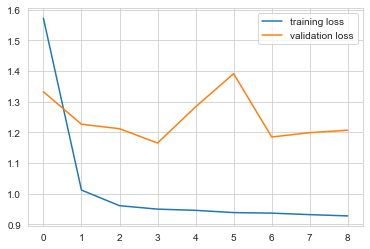

In [38]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

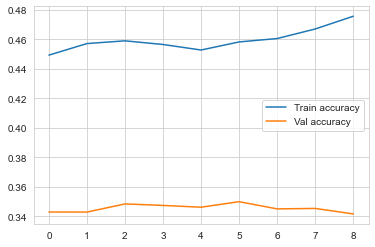

In [39]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [40]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,12,8224,367
actual 1,14,8566,469
actual 2,21,8271,433


In [41]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3418059933761622

In [42]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3412135539795114

In [43]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.34177744018230155

In [44]:
rnn_proba = model.predict_proba(test_sequence)

In [45]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.090383,0.487553,0.422063
1,0.102549,0.482119,0.415332
2,0.104751,0.483437,0.411812
3,0.094055,0.493837,0.412108
4,0.088135,0.500584,0.411281


In [46]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [47]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,1,1,0.090383,0.487553,0.422063
2015-10-01 20:00:00,20,1,1,1,0.102549,0.482119,0.415332
2015-10-01 21:00:00,21,2,1,0,0.104751,0.483437,0.411812
2015-10-01 22:00:00,22,1,1,1,0.094055,0.493837,0.412108
2015-10-01 23:00:00,23,1,1,1,0.088135,0.500584,0.411281


In [48]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,1,1,0.090383,0.487553,0.422063
2015-10-01 20:00:00,20,1,1,1,0.102549,0.482119,0.415332
2015-10-01 21:00:00,21,2,1,0,0.104751,0.483437,0.411812
2015-10-01 22:00:00,22,1,1,1,0.094055,0.493837,0.412108
2015-10-01 23:00:00,23,1,1,1,0.088135,0.500584,0.411281


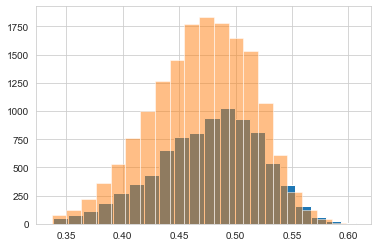

In [49]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [50]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 07:00:00,7,1,2,0,0.196767,0.400230,0.403003
2015-10-02 08:00:00,8,2,2,1,0.229642,0.378667,0.391691
2015-10-09 14:00:00,14,0,2,0,0.112283,0.441429,0.446288
2015-10-15 09:00:00,9,1,2,0,0.135727,0.427577,0.436696
2015-10-15 10:00:00,10,2,2,1,0.150603,0.408248,0.441149


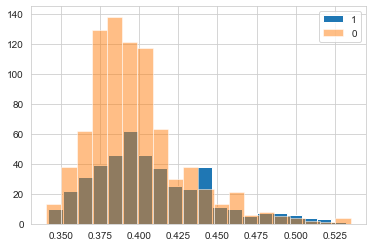

In [51]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [52]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 5

In [53]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [54]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [55]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [56]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [57]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 22s 72ms/step - loss: 1.6591 - categorical_accuracy: 0.4443 - val_loss: 1.4281 - val_categorical_accuracy: 0.3383
Epoch 2/50
310/310 [==============================] - 21s 69ms/step - loss: 1.0457 - categorical_accuracy: 0.4525 - val_loss: 1.2206 - val_categorical_accuracy: 0.3377
Epoch 3/50
310/310 [==============================] - 21s 69ms/step - loss: 0.9696 - categorical_accuracy: 0.4559 - val_loss: 1.2445 - val_categorical_accuracy: 0.3318
Epoch 4/50
310/310 [==============================] - 21s 69ms/step - loss: 0.9512 - categorical_accuracy: 0.4574 - val_loss: 1.2163 - val_categorical_accuracy: 0.3429
Epoch 5/50
310/310 [==============================] - 22s 70ms/step - loss: 0.9448 - categorical_accuracy: 0.4567 - val_loss: 1.1699 - val_categorical_accuracy: 0.3376
Epoch 6/50
310/310 [==============================] - 24s 77ms/step - loss: 0.9372 - categorical_accuracy: 0.4626 - val_loss: 1.1850 - val_categorical_accuracy:

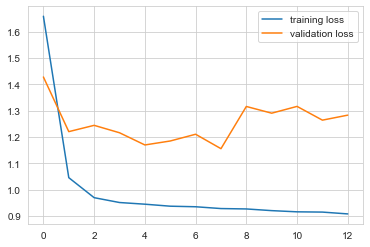

In [58]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

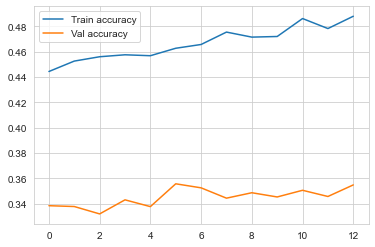

In [59]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [60]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,147,6062,2394
actual 1,96,6066,2885
actual 2,110,5472,3143


In [61]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3446590909090909

In [62]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.37318926620755166

In [63]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35389285988778724

In [64]:
rnn_proba = model.predict_proba(test_sequence)

In [65]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.080382,0.454376,0.465242
1,0.073243,0.442698,0.484059
2,0.097622,0.435588,0.466790
3,0.082168,0.449214,0.468618
4,0.070103,0.451194,0.478703


In [66]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [67]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,2,2,1,0.080382,0.454376,0.465242
2015-10-01 22:00:00,22,1,2,0,0.073243,0.442698,0.484059
2015-10-01 23:00:00,23,1,2,0,0.097622,0.435588,0.466790
2015-10-02 00:00:00,0,1,2,0,0.082168,0.449214,0.468618
2015-10-02 01:00:00,1,1,2,0,0.070103,0.451194,0.478703


In [68]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 10:00:00,10,2,1,0,0.154534,0.443846,0.401620
2015-10-02 11:00:00,11,2,1,0,0.146593,0.486648,0.366759
2015-10-02 12:00:00,12,1,1,1,0.150632,0.525362,0.324006
2015-10-02 13:00:00,13,1,1,1,0.093344,0.591799,0.314857
2015-10-02 14:00:00,14,1,1,1,0.054262,0.638511,0.307227


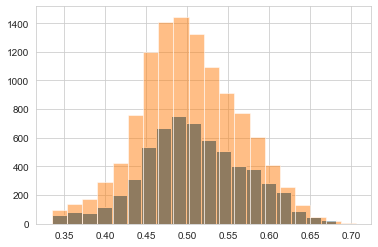

In [69]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [70]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,2,2,1,0.080382,0.454376,0.465242
2015-10-01 22:00:00,22,1,2,0,0.073243,0.442698,0.484059
2015-10-01 23:00:00,23,1,2,0,0.097622,0.435588,0.466790
2015-10-02 00:00:00,0,1,2,0,0.082168,0.449214,0.468618
2015-10-02 01:00:00,1,1,2,0,0.070103,0.451194,0.478703


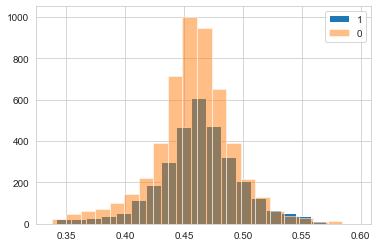

In [71]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [72]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 7

In [73]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [74]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [75]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [76]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [77]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 29s 92ms/step - loss: 1.6826 - categorical_accuracy: 0.4454 - val_loss: 1.3997 - val_categorical_accuracy: 0.3433
Epoch 2/50
310/310 [==============================] - 28s 90ms/step - loss: 1.0701 - categorical_accuracy: 0.4526 - val_loss: 1.2109 - val_categorical_accuracy: 0.3386
Epoch 3/50
310/310 [==============================] - 28s 91ms/step - loss: 0.9763 - categorical_accuracy: 0.4500 - val_loss: 1.1716 - val_categorical_accuracy: 0.3407
Epoch 4/50
310/310 [==============================] - 28s 92ms/step - loss: 0.9530 - categorical_accuracy: 0.4598 - val_loss: 1.2208 - val_categorical_accuracy: 0.3368
Epoch 5/50
310/310 [==============================] - 29s 92ms/step - loss: 0.9432 - categorical_accuracy: 0.4625 - val_loss: 1.3149 - val_categorical_accuracy: 0.3327
Epoch 6/50
310/310 [==============================] - 28s 92ms/step - loss: 0.9390 - categorical_accuracy: 0.4661 - val_loss: 1.2701 - val_categorical_accuracy:

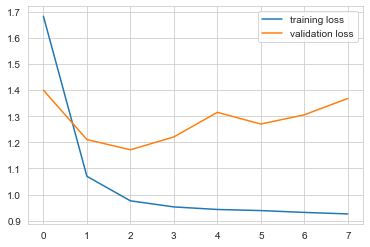

In [78]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

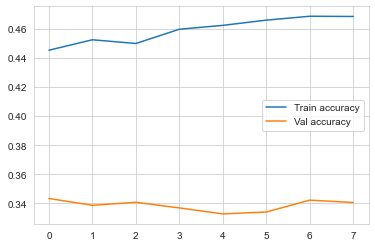

In [79]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [80]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,5247,3356
actual 1,0,4635,4411
actual 2,0,4378,4346


In [81]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.32503506311360447

In [82]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.35878807892347064

In [83]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.340537671103022

In [84]:
rnn_proba = model.predict_proba(test_sequence)

In [85]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.064396,0.443374,0.492230
1,0.053293,0.440536,0.506171
2,0.050956,0.442925,0.506120
3,0.046733,0.443141,0.510125
4,0.047776,0.436383,0.515841


In [86]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [87]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,2,0,0.064396,0.443374,0.492230
2015-10-02 00:00:00,0,1,2,0,0.053293,0.440536,0.506171
2015-10-02 01:00:00,1,1,2,0,0.050956,0.442925,0.506120
2015-10-02 02:00:00,2,1,2,0,0.046733,0.443141,0.510125
2015-10-02 03:00:00,3,1,2,0,0.047776,0.436383,0.515841


In [88]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 09:00:00,9,2,1,0,0.073227,0.466747,0.460026
2015-10-02 10:00:00,10,2,1,0,0.118179,0.496048,0.385772
2015-10-02 11:00:00,11,2,1,0,0.158793,0.490579,0.350627
2015-10-02 12:00:00,12,1,1,1,0.166444,0.488759,0.344797
2015-10-02 13:00:00,13,1,1,1,0.143927,0.504876,0.351198


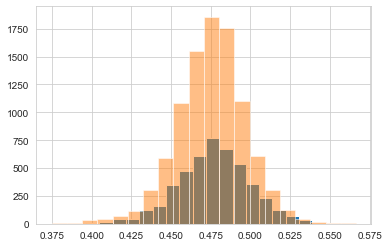

In [89]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [90]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,2,0,0.064396,0.443374,0.492230
2015-10-02 00:00:00,0,1,2,0,0.053293,0.440536,0.506171
2015-10-02 01:00:00,1,1,2,0,0.050956,0.442925,0.506120
2015-10-02 02:00:00,2,1,2,0,0.046733,0.443141,0.510125
2015-10-02 03:00:00,3,1,2,0,0.047776,0.436383,0.515841


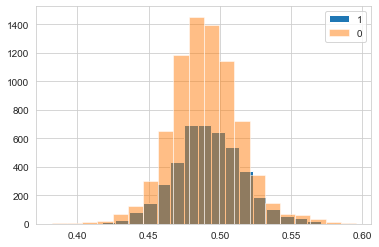

In [91]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()